# Uso del Machine Learning para predecir el riesgo de perdida de clientes en el banco BETA BANK

La empresa bancaria Beta Bank esta experimentando la perdida de clientes, mes a mes lo clientes estan cerrando suys cuentas con el banco. Los analistas financieron descubrieron que es mas economico salvar a los clientes existentes que atraer nuevos.

Tenemos acceso a los datos sobre el comportamiento pasado de los clientes y sobre aquellos que han dado de baja a los contratos con el banco.

Desarrollaremos un modelo que nos permita predecir si un cliente dejará el banco pronto. El modelo debe obtener un valor de `metrica F1 de al menos 0.59`. Además, mediremos la `métrica AUC-ROC`.


Para el desarrollo del modelo usaremos la dataset `Churn` y aplicaremos los siguientes algoritmos de machine learning:

- Logistic Regression
- Decision Tree
- Random Forest

Los datos generales se dividirán en conjuntos de entrenamiento, validación y prueba. Los modelos se entrenarán y ajustarán utilizando los conjuntos de entrenamiento y validación, con el objetivo de optimizar los hiperparámetros para lograr la máxima exactitud. Una vez establecidos los hiperparámetros óptimos, los modelos se evaluarán utilizando el conjunto de prueba y se seleccionará el que tenga la mayor exactitud como modelo final.

### 1.- IMPORTAMOS LIBRERIAS

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Hide warning messages
import warnings
warnings.filterwarnings('ignore')

### 2.-  CARGA DE LA DATA

El archivo csv `Churn` sera leido y almacenado en la dataframe `df`.

In [ ]:
df = pd.read_csv('../SP 10 BETABANK PREDICCION DE BAJA DE CLIENTE/dataset/Churn.csv')

### 3.- EXPLORANDO LA DATA

### 3.1 Descripcion de los datos:

#### Características

- `RowNumber`: índice de cadena de datos
- `CustomerId`: identificador de cliente único
- `Surname`: apellido
- `CreditScore`: valor de crédito
- `Geography`: país de residencia
- `Gender`: sexo
- `Age`: edad
- `Tenure`: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
- `Balance`: saldo de la cuenta
- `NumOfProducts`: número de productos bancarios utilizados por el cliente
- `HasCrCard`: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
- `IsActiveMember`: actividad del cliente (1 - sí; 0 - no)
- `EstimatedSalary`: salario estimado

#### Objetivo

- `Exited`: El cliente se ha ido (1 - sí; 0 - no)

In [13]:
# Mostramos la data
print(df.info()) 
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6127,6128,15708693,Sherman,759,France,Female,33,2.0,0.00,2,1,0,56583.88,0
8756,8757,15784923,Chimezie,705,Germany,Female,37,3.0,109974.22,1,1,1,36320.87,1
5523,5524,15625586,Monaldo,717,France,Male,35,4.0,0.00,1,1,1,167573.06,0
9729,9730,15615330,Tretiakova,651,France,Male,23,10.0,0.00,2,1,1,170099.23,0
7013,7014,15599440,McGregor,748,France,Female,34,NaN,0.00,2,1,0,53584.03,0
9078,9079,15705448,Gilbert,647,Germany,Male,52,7.0,130013.12,1,1,1,190806.36,1
9938,9939,15593496,Korovin,526,Spain,Female,36,NaN,91132.18,1,0,0,58111.71,0
81,82,15663706,Leonard,777,France,Female,32,2.0,0.00,1,1,0,136458.19,1
3511,3512,15674727,Lazarev,777,France,Female,42,5.0,147531.82,1,1,1,38819.45,0
4665,4666,15656293,Davey,786,France,Male,35,3.0,0.00,2,1,0,92712.97,0


La dataframe `df` tiene 10,000 filas and 14 columns. 

Observaciones: 
- La columna `Tenure` tiene `909` valores perdidos, el cual corresponde al 9% de la data por lo que no podemos eliminar las filas y la data de la columan debe ser completada con la media de los valores de `Ternure`. 
- La columna `RowNumber`, `CustomerId `, `Surname`, `Geography` y `Gender` no aportan como caracteristicas al modelo, debido a que son datos strings o no numericos, por lo que seran procesadas en la etapa de modelamiento mediante metodos de codificacion.

### 3.2 Pre procesamiento de datos:

Los datos perdidos de la columna `Tenure` seran reemplazdos por la media de la columna.

In [16]:
# Filtramos las filas perdidos con .isna() dentro de .loc() para seleccionar las filas NaN de la columna 'Ternure'
# Estos datos seran iguales a la media de la columa 'Ternure' para lo cual usamos .median()

df.loc[df['Tenure'].isna(),'Tenure'] = df['Tenure'].median()

Exploramos nuevamente la dataframe para cerciorarnos que la data perdida ha sido rellenada.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


## 4.- MODELAMIENTO

### 4.1 Preparacion de las caracteristicas:

Antes de dividir la datra y entrenar el modelo, debemos preparar las caracteristicas, esta debe ser data numerica para evitar errores, por lo que cualquier columna no-numerica o strings debe ser transformado usando metodos de codificacion. Asimismo, otra condicion para codificar los datos es que estos deben contener pocos valores unicos, por lo que contaremos los valores unicos de las columnas.

In [ ]:
a = df.columns
for i in a:
    print(i,' - tiene: ', df[i].nunique(), 'valores unicos')

RowNumber  - tiene:  10000 valores unicos
CustomerId  - tiene:  10000 valores unicos
Surname  - tiene:  2932 valores unicos
CreditScore  - tiene:  460 valores unicos
Geography  - tiene:  3 valores unicos
Gender  - tiene:  2 valores unicos
Age  - tiene:  70 valores unicos
Tenure  - tiene:  11 valores unicos
Balance  - tiene:  6382 valores unicos
NumOfProducts  - tiene:  4 valores unicos
HasCrCard  - tiene:  2 valores unicos
IsActiveMember  - tiene:  2 valores unicos
EstimatedSalary  - tiene:  9999 valores unicos
Exited  - tiene:  2 valores unicos


Las columnas `RowNumber`, `CustomerId` y `Surname` tienen entre 2932 y 10000 valores unicos por lo que no podemos codificarlos, ademas, no impactan dentro de las caracteristicas para la evaluacion de abandono de clientes, por lo que se creara una nueva dataframe llamada `data_filtrada` la cual sera creada removiendo las columnas `RowNumber`, `CustomerId` y `Surname` .

In [86]:
data_filtrada = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Ahora las columnas `Geography` y `Gender`tienen 3 y 2 valores unicos respectivamente, realizaremos One-Hot Encoding un metodo adecuado para codificar variables categoricas ideal para los algoritmos `Logistic Regression`, `Decision Tree` y `Random Forest` que evaluaremos.

La dataframe codificada se llamara `data_OHE` y para evitar la trampa dummy utilizaremos el parametro `drop_first=True` dentro de la codificacion One-Hot `pd.get_dummies()`

In [ ]:
# Codificacion ONE-HOT de la dataframe data_filtrada
# Parametro drop_first=True, para eliminar la primera columna codificacda y evitar la trampoa dummyt
# Parametro dtype= int, para que las columnas generadas como data dummy sean de tipo int
data_OHE = pd.get_dummies(data_filtrada, drop_first=True, dtype= int)


Luego de la codificacion One-Hot, hecharemos un vistazo a la dataframe `data_ohe`

In [88]:
data_OHE

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


Las 3 ulitmas columnas son el resultado de codificar las columnas `Geography` y `Gender`. Toda la dataframe es ahora numerica y lista para entrenar.

### 4.2 Division de los conjuntos de datos:

Queremos poder entrenar el modelo, validarlo y luego realizar las pruebas finales del modelo. Estas acciones requieren 3 conjuntos de datos separados. Dado que Beta Bank solo ha proporcionado un conjunto de datos, se dividirá en un conjunto de datos de entrenamiento, un conjunto de datos de validación y un conjunto de datos de prueba. Una proporción popular para dividir los datos es 3:1:1, donde el conjunto de datos de entrenamiento contiene el 60 % de los datos y tanto el conjunto de datos de validación como el de prueba contienen el 20 % de los datos. Para dividir los datos, utilizaremos la función `train_test_split` que se encuentra en la biblioteca `sklearn.model_selection`. El siguiente bloque de celdas dividirá el conjunto de datos general en 3 conjuntos de datos separados.

In [94]:
# Creamos los conjuntos de datos de entrenamiento (train), validacion (valid) y prueb (test)
# La dataframe sera divida en 60%, 20%, 20% para una relacion de 3:1:1.

# Creamos la df 'target' compuesta por la columna 'Exited'
target = data_OHE['Exited']

# Creamos la df 'features' retirando la clumna 'Exited'
features = data_OHE.drop('Exited', axis=1)

# Dividimos la df target y features en dataset 'training' y 'other' con el 60%  y 40 de la data respectivamente.
features_train, features_other, target_train, target_other = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)

# Dividiremos la dataset 'other'en las dataset de validation y testing
# El parametro test_size sera 0.5 para que cada dataset contenga el 50% del 40% de la data
# O el 20% del total de la data respectivament.
features_valid, features_test, target_valid, target_test = train_test_split(features_other,
                                                                            target_other, 
                                                                            test_size=0.5, 
                                                                            random_state=12345)

### 4.3 Prueba de consistencia:

Ahora que los datos se han dividido, examinemos la distribución de clases positivas y negativas en cada conjunto de datos. Calcularemos la proporción de instancias positivas y negativas en cada uno de los conjuntos de datos de entrenamiento, validación y prueba y mostraremos los resultados.

Target_Train
El balance de clases para Target_Train es:  Exited
0    80.07
1    19.93
Name: proportion, dtype: float64 


Target_Valid
El balance de clases para Target_Valid es:  Exited
0    79.1
1    20.9
Name: proportion, dtype: float64 


Target_Test
El balance de clases para Target_Test es:  Exited
0    78.85
1    21.15
Name: proportion, dtype: float64 




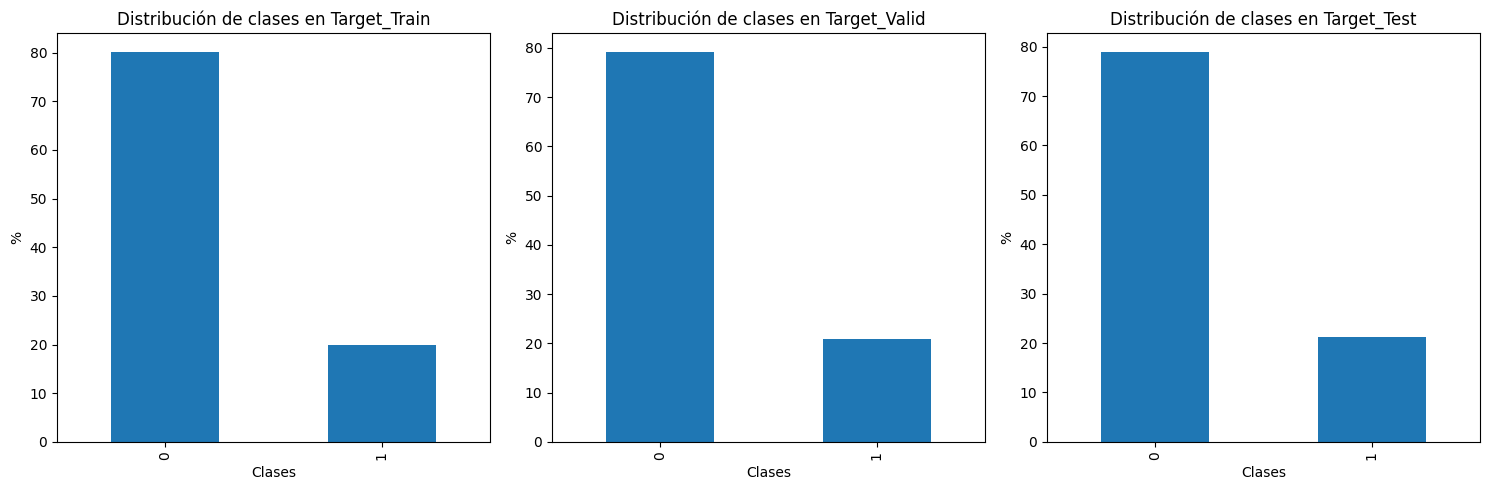

In [171]:
# Lista de DataFrames y sus nombres
datasets = [target_train, target_valid, target_test]
dataset_names = ['Target_Train', 'Target_Valid', 'Target_Test']

# Crear una figura para los gráficos
plt.figure(figsize=(15, 5))  # Tamaño de la figura (ancho, alto)

# Ciclo para iterar sobre los datasets y graficar
for i, (dataset, name) in enumerate(zip(datasets, dataset_names)):
    # Obtener los conteos de valores en la columna 'columna'
    counts = round(dataset.value_counts(normalize=True)* 100,2)
    print(name)
    print(f'El balance de clases para {name} es: ', counts,'\n\n')
    

    # Crear el gráfico de barras en una subgráfica (subplot)
    plt.subplot(1, 3, i + 1)  # 1 fila, 3 columnas, y el gráfico en la posición i+1
    counts.plot(kind='bar')
    
    # Agregar título y etiquetas
    plt.title(f"Distribución de clases en {name}")
    plt.xlabel('Clases')
    plt.ylabel('%')

# Ajustar el layout para que los gráficos no se sobrepongan
plt.tight_layout()

# Mostrar los gráficos
plt.show()

El desequilibrio de clases significativo se puede observar en los conjuntos de datos de objetivos de `train`, `valid` y `test` donde la clase negativa (0) constituye el 80% mientras que la clase positiva (1) solo representa el 20%. Para mejorar la capacitación y los resultados del modelo, es necesario corregir este desequilibrio. Para demostrar el impacto de la corrección del equilibrio de clases, compararemos el rendimiento de un modelo entrenado sin corrección del equilibrio de clases con otro modelo entrenado después de la corrección. Antes del entrenamiento, debemos estandarizar los datos para tratar cada característica por igual usando la clase `StandardScaler` del módulo `sklearn.preprocessing`, que se realiza en el siguiente bloque de celdas.

### 4.4 Estandarizacion de caracteristicas:
Estandarizaremos las caracteristicas (features) de los dataset para que el modelo interpete las caracteristicas por igual y no exista una mas importante que otra debido a su valor numerico.

In [172]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

Ahora que los datos están estandarizados para los conjuntos de datos de `train`, `valid` y `test`.

### 4.5 Entrenamiento de modelos:

Entrenaremos los modelos usando los siguientes algoritmos:

- Logistic Regression
- Decision Tree
- Random Forest

Evaluaremos las metricas `F1` y  `AUC_ROC` para cada modelo y compararemos los modelos ajustando el `balance de clases`, `el peso de la clase`, `el sobremuestreo` y `el submuestreo`.

#### 4.5.1 Logistic Regression:

##### A) Logistic Regression: Entrenar el modelo antes de ajustar el desequilibrio de clases

Entrenaremos el modelos sin ajustar el desequilibrio de clases. Luego, compararemos los resultados con el modelo entrenado después de haber ajustado el desequilibrio de clases.

In [ ]:
# Creamos la instancia del modelo
model = LogisticRegression(solver='liblinear', random_state=12345)

# Entrenamos el modelo utilizando los datos de entrenamiento
model.fit(features_train, target_train)

# Predecimos los valores target de las features_valid
predicted_valid = model.predict(features_valid)

# Calculamos y mostramos la puntuiacion de las metricas F1 y AUC-ROC
print('A) Logistic Regression: Entrenar el modelo antes de ajustar el desequilibrio de clases')
print('F1:', round(f1_score(target_valid, predicted_valid),5))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'AUC-ROC puntuacion: {round(auc_roc, 5)}')

A) Logistic Regression: Entrenar el modelo antes de ajustar el desequilibrio de clases
F1: 0.33108
AUC-ROC puntuacion: 0.75875


La `puntuación F1` del modelo de Logistic Regression es de `0,33` sin ajuste por desequilibrio de clases, lo cual es decente pero no satisfactorio. Este modelo no sería adecuado para Beta Bank. `La puntuación AUC-ROC` es aproximadamente `0,76`, que es mejor que un modelo aleatorio, pero aún no es ideal. Evaluamos el desempeño del modelo después de ajustar el desequilibrio de clases.

##### B) Logistic Regression: Entrenar el modelo despues de ajustar el desequilibrio de clases

Para mejorar la puntuación F1 del modelo de Logistic Regression, intentaremos equilibrar el desequilibrio de clases en el conjunto de datos de entrenamiento. Al ajustar el peso de la clase, el modelo conocerá las clases más frecuentes. Esto se puede lograr estableciendo el parámetro `class_weight = balanced` al inicializar el modelo.

In [ ]:
# Creamos la instancia del modelo
# Seteamos el parametro class_weight='balanced'
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345)

# Entrenamos el modelo utilizando los datos de entrenamiento
model.fit(features_train, target_train)

# Predecimos los valores target de las features_valid
predicted_valid = model.predict(features_valid)

print('B) Logistic Regression: Entrenar el modelo despues de ajustar el desequilibrio de clases')

# Calculamos y mostramos la puntuiacion de las metricas F1 y AUC-ROC
print('F1:', round(f1_score(target_valid, predicted_valid),5))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'AUC-ROC Score: {round(auc_roc, 5)}')

B) Logistic Regression: Entrenar el modelo despues de ajustar el desequilibrio de clases
F1: 0.48885
AUC-ROC Score: 0.76373


Después de equilibrar el desequilibrio de clases, `la puntuación F1` del modelo de Logistic Regression mejoró a aproximadamente `0,49`, en comparación con la puntuación anterior de 0,33. Aunque la puntuación mejoró, todavía `no alcanza el mínimo requerido de 0,59` establecido por Beta Bank. `La puntuación AUC-ROC` también mejoró ligeramente a `0.761`. Ahora probaremos otros métodos para ajustar el desequilibrio de clases y entrenaremos diferentes modelos para encontrar la mejor solución.

##### C) Logistic Regression: Ajustar el peso de la clase con submuestreo y sobremuestreo.

Para abordar aún más el desequilibrio de clases, además de usar `class_weight='balanced`, también podemos aplicar:

- `Sobremuestreo`:  El cual consiste en aumentar el número de muestras de la clase minoritaria en el conjunto de datos para que tenga un número similar de instancias que la clase mayoritaria. Este proceso se puede hacer duplicando muestras de la clase minoritaria o generando nuevas muestras sintéticas.

- `Submuestreo`: El cual consiste en reducir el número de muestras de la clase mayoritaria para igualar el número de muestras con la clase minoritaria. Esto se puede hacer eliminando aleatoriamente muestras de la clase mayoritaria. Este proceso se puede hacer duplicando muestras de la clase minoritaria o generando nuevas muestras sintéticas.

Examinaremos los siguientes casso.

#### Oversampling

In [198]:
# Ajustamos el desbalance de clases con Sobremuestreo

# Creamos una función de sobremuestreo de los datos de entrenamiento

# Inicializacion de la funcion
def oversample(features, target, repeat):
    
    # Creamos las dataset basado en las clases
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # realizar el Sobremuestreo
    features_oversampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_oversampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # Mezclamos las observaciones
    features_oversampled, target_oversampled = shuffle(features_oversampled, target_oversampled, random_state=12345)
    
    # Return the upsampled data
    return features_oversampled, target_oversampled

Ahora que se ha creado una función para el sobremuestreo, pasemos las características y los conjuntos de datos de destino del conjunto de datos de entrenamiento a la función.

In [199]:
features_oversampled, target_oversampled = oversample(features_train, target_train, 10)

Ahora veamos cómo el sobremuestreo afecta el rendimiento del modelo de regresión logística.

In [200]:
# Creamos la instancia del model 
model = LogisticRegression(solver='liblinear', random_state=12345)

# Entrenamos el modelo utilizando los datos de sobremuestreo
model.fit(features_oversampled, target_oversampled)

# Predecimos los valores target de las features_valid
predicted_valid = model.predict(features_valid)

print('C) Logistic Regression: Ajustar el peso de la clase con submuestreo y sobremuestreo')
print('Upsampling')

# Calculamos y mostramos la puntuiacion de las metricas F1 y AUC-ROC
print('F1:', round(f1_score(target_valid, predicted_valid),5))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'AUC-ROC Score: {round(auc_roc, 5)}')

C) Logistic Regression: Ajustar el peso de la clase con submuestreo y sobremuestreo
Upsampling
F1: 0.41943
AUC-ROC Score: 0.76535


`La puntuación F1` del modelo después de realizar `sobremuestreo` de los datos es de aproximadamente `0,42`, lo que no es tan bueno como `la puntuación anterior` de aproximadamente `0,49` obtenida utilizando el parámetro `class_weight='balanced'`. No obstante, es mejor que no ajustar en absoluto el desequilibrio de clases. `La puntuación AUC-ROC` es similar a la que se observó anteriormente en el modelo con el parámetro `class_weight='balanced'`. Ahora, intentemos realizar un submuestreo para ver el efecto en el modelo.

#### Subsampling

In [189]:
# Ajustamos el desbalance de clases con Submuestreo

# Creamos una función de submuestreo de los datos de entrenamiento

# Inicializacion de la funcion

def subsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_subsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_subsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_subsampled, target_subsampled = shuffle(features_subsampled, target_subsampled, random_state=12345)

    return features_subsampled, target_subsampled

Ahora que se ha creado una función para el submuestreo, pasemos las características y los conjuntos de datos de destino del conjunto de datos de entrenamiento a la función.

In [202]:
features_subsampled, target_subsampled = subsample(features_train, target_train, 0.1)

Ahora veamos cómo el submuestreo afecta el rendimiento del modelo de regresión logística.

In [203]:
# Creamos la instancia del modelo
model = LogisticRegression(solver='liblinear', random_state=12345)

# Entrenamos el modelo utilizando los datos de submuestreo
model.fit(features_subsampled, target_subsampled)

# Predecimos los valores target de las features_valid
predicted_valid = model.predict(features_valid)

print('C) Logistic Regression: Ajustar el peso de la clase con submuestreo y sobremuestreo')
print('Subsampling')

# Calculamos y mostramos la puntuiacion de las metricas F1 y AUC-ROC
print('F1:', f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'AUC-ROC Score: {round(auc_roc, 5)}')

C) Logistic Regression: Ajustar el peso de la clase con submuestreo y sobremuestreo
Subsampling
F1: 0.4308390022675737
AUC-ROC Score: 0.75836


El nuevo modelo tiene una `puntuación F1` de aproximadamente `0,43`, lo que supone una mejora con respecto al modelo con datos mejorados, pero no tan bueno como el que utiliza el `parámetro `class_weight='balanced'`. `La puntuación AUC-ROC` se mantiene prácticamente `sin cambios` y ha disminuido ligeramente en comparación con los dos modelos anteriores. Una vez completada la exploración del modelo de Logistic Regression, es hora de evaluar el rendimiento de los modelos de Decision Tree y Random Forest.

#### 4.5.2 DECISION TREE:

##### A) Decision Tree: Entrenar el modelo despues de ajustar el desequilibrio de clases

In [212]:
# Modelo Decision Tree

# Inicializamos
best_DT_model = None
best_DT_f1_score = 0
best_DT_depth = 0

# Creamos varios modelos con diferentes max_depth 

# Ciclo for para evaluar el parametro max_depth (range of 1-41)
for depth in range(1,41):
    
    # Cree un modelo, variando el max_depth y con el mismo random_state
    DT_model = DecisionTreeClassifier(class_weight='balanced', max_depth=depth, random_state=12345)
    
    # Entrenamos el modelo usando la data de entrenamiento
    DT_model.fit(features_train, target_train)
    
    # Predecimos los valores target de las features_valid
    DT_predictions_valid = DT_model.predict(features_valid) 
    
    # Calculamos y mostramos la puntuiacion de las metricas F1 y AUC-ROC
    try:
        f1 = f1_score(target_valid, DT_predictions_valid)
    except:
        break
        
    # Determinamos el mejor ajuste
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model
        best_DT_depth = depth
        best_DT_f1_score = f1

probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('A) Decision Tree: Entrenar el modelo despues de ajustar el desequilibrio de clases')
print('El mejor modelo:', best_DT_model)
print(f'F1: {round(best_DT_f1_score,4)}')
print(f'AUC-ROC: {round(auc_roc, 5)}')
print('El mejor Depth:', best_DT_depth)

A) Decision Tree: Entrenar el modelo despues de ajustar el desequilibrio de clases
El mejor modelo: DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
F1: 0.5964
AUC-ROC: 0.83102
El mejor Depth: 5


El modelo de Decision Tree con `class_weight='balanced'` tiene `la puntuación F1` más alta hasta el momento, alrededor de `0,596`. `La puntuación AUC-ROC` es de 0.831` correspondiente también es la más alta observada hasta ahora.

##### B) Decision Tree: Entrenar el modelo con sobremuestreo

In [211]:
# Modelo Decision Tree

# Inicializamos
best_DT_model = None
best_DT_f1_score = 0
best_DT_depth = 0

# Creamos varios modelos con diferentes max_depth 

# Ciclo for para evaluar el parametro max_depth (range of 1-41)
for depth in range(1,41):
    
    # Cree un modelo, variando el max_depth y con el mismo random_state
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Entrenamos el modelo usando la data de sobremuestreo
    DT_model.fit(features_oversampled, target_oversampled)
    
    # Predecimos los valores target de las features_valid
    DT_predictions_valid = DT_model.predict(features_valid) 
    
    # Calculamos y mostramos la puntuiacion de las metricas F1 y AUC-ROC
    try:
        f1 = f1_score(target_valid, DT_predictions_valid)
    except:
        break
    
    # Determinamos el mejor ajuste
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model
        best_DT_depth = depth
        best_DT_f1_score = f1

probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('B) Decision Tree: Entrenar el modelo con sobremuestreo')
print('Mejor Model:', best_DT_model)
print(f'F1: {round(best_DT_f1_score,4)}')
print(f'AUC-ROC: {round(auc_roc, 5)}')
print('Mejor Depth:', best_DT_depth)

B) Decision Tree: Entrenar el modelo con sobremuestreo
Mejor Model: DecisionTreeClassifier(max_depth=7, random_state=12345)
F1: 0.5252
AUC-ROC: 0.8126
Mejor Depth: 7


El modelo de Decision Tree con datos sobremuestrados ha mejorado la `puntuación F1` con `0.52` y `la puntuiacion de AUC-ROC` con `0.81`, en comparación con los modelos de Logistic Regression con el parámetro `class_weight='balanced'` se muestra un mejor rendimiento en términos de puntuación F1 y AUC-ROC.

##### C) Decision Tree: Entrenar el modelo con submuestreo

In [215]:
# Modelo Decision Tree

# Inicializamos
best_DT_model = None
best_DT_f1_score = 0
best_DT_depth = 0

# Creamos varios modelos con diferentes max_depth 

# Ciclo for para evaluar el parametro max_depth (range of 1-41)
for depth in range(1,41):
    
    # Cree un modelo, variando el max_depth y con el mismo random_state
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Entrenamos el modelo usando la data de submuestreo
    DT_model.fit(features_subsampled, target_subsampled)
    
    # Predecimos los valores target de las features_valid
    DT_predictions_valid = DT_model.predict(features_valid) 
    
    # Calculamos y mostramos la puntuiacion de las metricas F1 y AUC-ROC
    try:
        f1 = f1_score(target_valid, DT_predictions_valid)
    except:
        break
    
    # Determinamos el mejor ajuste
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model
        best_DT_depth = depth
        best_DT_f1_score = f1
        
probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('C) Decision Tree: Entrenar el modelo con submuestreo')
print('Mejor Model:', best_DT_model)
print(f'F1: {round(best_DT_f1_score,4)}')
print(f'AUC-ROC: {round(auc_roc, 5)}')
print('Merjor Depth:', best_DT_depth)

C) Decision Tree: Entrenar el modelo con submuestreo
Mejor Model: DecisionTreeClassifier(max_depth=5, random_state=12345)
F1: 0.4955
AUC-ROC: 0.81491
Merjor Depth: 5


El modelo de árbol de decisión que utiliza datos de submuestrados tiene una `puntuación F1` de `0.495` y una `puntuación AUC-ROC` de `0.81`, puntuaciones mejores que los modelos de Logistic Regression, pero no superiores a las del modelo de LDecision Tree con el parámetro `class_weight='balanced'`.

#### 4.5.3 RANDOM FOREST:

##### A) Random Forest: Entrenar el modelo despues de ajustar el desequilibrio de clases

In [ ]:
# Modelo Random Forest

# Inicializamos
best_RF_model = None
best_est = 0
best_RF_depth = 0
best_RF_f1_score = 0

# Creamos varios modelos con diferentes max_depth 

# Ciclo for para evaluar el parametro n_estimators (range of 1-21)
for est in range(1,21):
    
    # Ciclo for para evaluar el parametro max_depth (range of 1-41)
    for depth in range (1, 41):
        
        # Creamos el modelo, variando el max_depth, variando el n_estimators y con el mismo random_state
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Entrenamos el modelo usando la data de entrenamiento
        RF_model.fit(features_train, target_train)

        # Predecimos los valores target de las features_valid
        RF_predictions_valid = RF_model.predict(features_valid) 
       
        # Calculamos y mostramos la puntuiacion de las metricas F1 y AUC-ROC
        try:
            f1 = f1_score(target_valid, RF_predictions_valid)
        except:
            break

     # Determinamos el mejor ajuste
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('A) Random Forest: Entrenar el modelo despues de ajustar el desequilibrio de clases')
print('Mejor Model:', best_RF_model)
print(f'F1: {round(best_RF_f1_score, 4)}')
print(f'AUC-ROC: {round(auc_roc, 5)}')
print('Mejor Depth:', best_RF_depth)
print('Mejor n_estimators:', best_est)

A) Random Forest: Entrenar el modelo despues de ajustar el desequilibrio de clases
Mejor Model: RandomForestClassifier(max_depth=14, n_estimators=9, random_state=12345)
F1: 0.6
AUC-ROC: 0.82229
Mejor Depth: 14
Mejor n_estimators: 9


El modelo Random Forest con el parámetro `class_weight='balanced'` tiene `la mejor` `puntuación F1` hasta el momento, aproximadamente `0,6`, superando la puntuación F1 de los modelos de árbol de decisión. Esta puntuación `cumple con el requisito mínimo de puntuación F1 de 0,59` establecido por Beta Bank. Además, su `puntuación AUC-ROC` de alrededor de `0,82` es la más alta vista hasta ahora.

##### B) Random Forest: Entrenar el modelo con sobremuestreo

In [218]:
# Modelo Random Forest

# Inicializamos
best_RF_model = None
best_est = 0
best_RF_depth = 0
best_RF_f1_score = 0

# Creamos varios modelos con diferentes max_depth 

# Ciclo for para evaluar el parametro n_estimators (range of 1-21)
for est in range(1,21):
    
    # Ciclo for para evaluar el parametro max_depth (range of 1-41)
    for depth in range (1, 41):
        
        # Creamos el modelo, variando el max_depth, variando el n_estimators y con el mismo random_state
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Entrenamos el modelo usando la data de sobremuestreo
        RF_model.fit(features_oversampled, target_oversampled)

        # Predecimos los valores target de las features_valid
        RF_predictions_valid = RF_model.predict(features_valid) # get model predictions on validation set
       
        # Calculamos y mostramos la puntuiacion de las metricas F1 y AUC-ROC
        try:
            f1 = f1_score(target_valid, RF_predictions_valid)
        except:
            break

     # Determinamos el mejor ajuste
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('B) Random Forest: Entrenar el modelo con sobremuestreo')
print('Mejor Model:', best_RF_model)
print(f'F1: {round(best_RF_f1_score, 4)}')
print(f'AUC-ROC: {round(auc_roc, 5)}')
print('Mejor Depth:', best_RF_depth)
print('Mejor n_estimators:', best_est)

B) Random Forest: Entrenar el modelo con sobremuestreo
Mejor Model: RandomForestClassifier(max_depth=14, n_estimators=20, random_state=12345)
F1: 0.6093
AUC-ROC: 0.82729
Mejor Depth: 14
Mejor n_estimators: 20


El modelo de Random Forest con datos sobremuestreados tiene una `puntuación F1` de `0.609` y una `puntuación AUC-ROC` de `0.827`, puntuaciones más altas que el modelo Random Forest con el parámetro `class_weight='balanced'`. `Las puntuaciones mas altas hasta el momento`.

##### C) Random Forest: Entrenar el modelo con submuestreo

In [219]:
# Modelo Random Forest

# Inicializamos
best_RF_model = None
best_est = 0
best_RF_depth = 0
best_RF_f1_score = 0

# Creamos varios modelos con diferentes max_depth 

# Ciclo for para evaluar el parametro n_estimators (range of 1-21)
for est in range(1,21):
    
    # Ciclo for para evaluar el parametro max_depth (range of 1-41)
    for depth in range (1, 41):
        
        # Creamos el modelo, variando el max_depth, variando el n_estimators y con el mismo random_state
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Entrenamos el modelo usando la data de submuestreo
        RF_model.fit(features_subsampled, target_subsampled)

        # Predecimos los valores target de las features_validl
        RF_predictions_valid = RF_model.predict(features_valid)
       
        # Calculamos y mostramos la puntuiacion de las metricas F1 y AUC-ROC
        try:
            f1 = f1_score(target_valid, RF_predictions_valid)
        except:
            break

     # Determinamos el mejor ajuste
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('C) Random Forest: Entrenar el modelo con submuestreo')
print('Mejor Modelo:', best_RF_model)
print(f'F1: {round(best_RF_f1_score, 4)}')
print(f'AUC-ROC: {round(auc_roc, 5)}')
print('Mejor Depth:', best_RF_depth)
print('Mejor n_estimators:', best_est)

C) Random Forest: Entrenar el modelo con submuestreo
Mejor Modelo: RandomForestClassifier(max_depth=15, n_estimators=10, random_state=12345)
F1: 0.4781
AUC-ROC: 0.79146
Mejor Depth: 15
Mejor n_estimators: 10


Desafortunadamente, el modelo de Random Forest con data submuestrada no funcionó bien. Su `puntuación F1` de alrededor de `0,48` es uno de los valores más bajos observados y comparable a los modelos de Logistic Regression. Asimismo, `la puntuación AUC-ROC` es de `0.791`, mejor a los modelos de Logistic Regression.

## 5.- FASE DE PRUEBA - TEST 

El modelo de mejor rendimiento fue el `Random Forest` con datos `sobremuestrados`, con un `max_depth` de `14` y un valor de `n_estimators` de `20`, según su puntuación F1 y su puntuación AUC-ROC. Entrenemos el modelo una vez más y evaluemos utilizando el conjunto de datos de prueba.

In [220]:
# Creamos un modelo, utilizando la max_depth, n_estimators y random_state proporcionados
RF_model = RandomForestClassifier(max_depth=14, random_state=12345, n_estimators=20)

# Entrenamos el modelo usando el conjunto de datos de entrenamiento.
RF_model.fit(features_oversampled, target_oversampled)

test_predictions = RF_model.predict(features_test)

f1 = f1_score(target_test, test_predictions)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(f'Puntuacion F1: {round(f1, 4)}')
print(f'Puntuacion AUC-ROC: {round(auc_roc, 4)}')

Puntuacion F1: 0.5931
Puntuacion AUC-ROC: 0.736


`El modelo Random Forest` que se entrenó tiene una `puntuación F1` de alrededor de `0,593`, lo que cumple con los `requisitos de Beta Bank`. La `puntuación AUC-ROC` es de `0.736`, es un valor razonable ya que supera a un modelo aleatorio. Sin embargo, es inferior a su rendimiento anterior en algunos conjuntos de datos de validación. Ahora comprobaremos cuántos de los 2000 clientes del conjunto de datos de prueba se prevé que se vayan.

In [221]:
# Inicializamos
total = 0

# Creamos un bucle for para verificar cada predicción en las predicciones de prueba.
for prediction in test_predictions:
    if prediction == 1:
        total += 1

# Imprimimos el número total de clientes que se prevé que abandonarán el banco.
print(total)

474


Approximately 25% of the 2,000 customers in the test dataset, or 474 customers, are predicted to leave the bank. This is a significant number, and Beta Bank should consider sending promotions.

Se prevé que aproximadamente el `25%` de los 2000 clientes en el conjunto de datos de prueba, o `474 clientes`, `abandonen el banco`. Este es un número significativo y Beta Bank debería considerar enviar promociones.

## 6.- CONCLUSION 

El paso inicial para cumplir con la solicitud de Beta Bank fue preprocesar los datos y las funciones. Las características se transformaron en forma numérica mediante el uso de One-Hot Encoding en características categóricas. Finalmente, todas las características se estandarizaron para garantizar la misma importancia.

Una vez que se procesaron previamente los datos, observamos un desequilibrio en las clases objetivo: la clase negativa representa alrededor del 80 % y la clase positiva representa solo el 20 % de los datos. Para evaluar el desempeño, se probó el modelo de Logistic Regression con el desequilibrio de clases original y los otros modelos se entrenaron con ajustes realizados para equilibrar el desequilibrio de clases.

El modelo con mejor rendimiento se determinó entrenando modelos de Logistic Regression, Decision Tree y Random Forest. Cada modelo se entrenó tres veces, y cada tipo de modelo utilizó un método diferente para ajustar el desequilibrio de clases en los datos objetivo. El primer modelo de cada tipo utilizó el parámetro `class_weight='balanced'`, el segundo modelo se entrenó con datos sobremuestrados y el tercer modelo se entrenó con datos submuestrados.

`El modelo con mejor rendimiento fue el Random Forest` entrenado con `datos sobremuestrados` utilizando una `max_ depth de 14` y `n_estimadores de 20`. El modelo se probó en el conjunto de datos de prueba y logró una `puntuación F1 de 0,5931`, que cumple con el requisito de puntuación mínima establecido por Beta Bank. . Por lo tanto, este modelo se considera una solución adecuada para que Beta Bank prediga la pérdida de clientes.